### Data downloading

Follow the [instructions in README.md](https://github.com/allenai/spoc-robot-training?tab=readme-ov-file#-downloading-assets-annotations-and-houses-) to get all data downloaded (annotations, assets, and houses).

In [ ]:
OBJAVERSE_DATA_DIR = "/path/to/objaverse_assets"  # use here the path where assets and annotations were downloaded to
OBJAVERSE_HOUSES_DIR = "/path/to/objaverse_houses"  # use here the path where houses were downloaded to

%set_env OBJAVERSE_DATA_DIR=$OBJAVERSE_DATA_DIR
%set_env OBJAVERSE_HOUSES_DIR=$OBJAVERSE_HOUSES_DIR

### Using annotations

This example shows how to load annotations and lists the contents for a random asset UID.

In [2]:
from utils.objaverse_annotation import get_objaverse_annotations
import random
import json

# Gets the annotation dict
annotation = get_objaverse_annotations()

print(f"{len(annotation)} entries")
print(f"Sample:\n{json.dumps(annotation[random.choice(list(annotation.keys()))], indent=2)}")

39664 entries
Sample:
{
  "uid": "86d928135d9547ba85110b700d9eb0e6",
  "description_auto": "Unicorn in a purple nebula.",
  "pose_z_rot_angle": 4.71,
  "size": [
    120,
    3,
    70
  ],
  "size_annotated_by": "gpt-4",
  "is_objaverse_plus": true,
  "split": "train",
  "category": "painting",
  "synset": "painting.n.01",
  "synset_labeled_by": "gpt-3.5",
  "most_specific_lemma": "painting",
  "description": "A painting of a unicorn with pink and purple sparkles surrounding it.",
  "scale": 1.2,
  "scale_annotated_by": "gpt-4",
  "z_axis_scale": false,
  "wn_version": "oewn:2022",
  "license_info": {
    "license": "by",
    "uri": "https://api.sketchfab.com/v3/models/86d928135d9547ba85110b700d9eb0e6",
    "creator_username": "VinlandProject",
    "creator_display_name": "VinlandProject",
    "creator_profile_url": "https://sketchfab.com/VinlandProject"
  },
  "ref_category": "Painting",
  "receptacle": false,
  "thor_metadata": {
    "assetMetadata": {
      "name": "86d928135d9547b

Let's find the frequency of (available) GPT-generated descriptions and list the most commonly appearing ones.

In [3]:
from collections import Counter
counts = Counter()
for entry in annotation.values():
    counts[entry["description_auto"]] += 1
print(f"Most common: {counts.most_common(5)}")

Most common: [(None, 6103), ('a wooden barrel.', 173), ('a wooden barrel', 68), ('a wooden chair.', 48), ('a wooden chair', 39)]


### Loading houses and required assets

First, let's see how to load house data. For example, load the first house from the `val` partition.

In [4]:
import os

import prior

from utils.constants.objaverse_data_dirs import OBJAVERSE_HOUSES_DIR

houses = prior.load_dataset(
    dataset="spoc-data",
    entity="spoc-robot",
    revision="local-objaverse-procthor-houses",
    path_to_splits=None,
    split_to_path={
        k: os.path.join(OBJAVERSE_HOUSES_DIR, f"{k}.jsonl.gz")
        for k in ["val"]
    },
    max_houses_per_split=1,
)['val']

print(f"{len(houses)} loaded val houses")
print(f"Sample room description:\n{json.dumps(houses[0]['rooms'][0], indent=2)}")

1 loaded val houses
Sample room description:
{
  "id": "room|4",
  "roomType": "Bedroom",
  "children": [],
  "ceilings": [],
  "floorPolygon": [
    {
      "x": 0.0,
      "y": 0,
      "z": 8.427
    },
    {
      "x": 6.32,
      "y": 0,
      "z": 8.427
    },
    {
      "x": 6.32,
      "y": 0,
      "z": 4.213
    },
    {
      "x": 0.0,
      "y": 0,
      "z": 4.213
    }
  ],
  "floorMaterial": {
    "name": "WhiteWood"
  },
  "layer": "Procedural2"
}


Now, let's load the house (and all required assets) as a THOR scene. The agent is the Stretch Robot with two RGB cameras (navigation and manipulation) used in our paper.

Using Controller commit id: 5e43486351ac6339c399c199e601c9dd18daecc3

nav


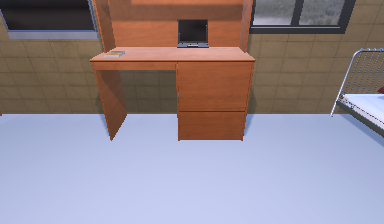


manip


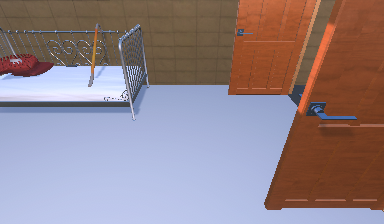

In [5]:
from PIL import Image

from environment.stretch_controller import StretchController
from utils.constants.stretch_initialization_utils import STRETCH_ENV_ARGS

c = StretchController(**STRETCH_ENV_ARGS)
event = c.reset(houses[0])

print("\nnav")
display(Image.fromarray(c.navigation_camera))
print("\nmanip")
display(Image.fromarray(c.manipulation_camera))

We can also easily extract available descriptions for objects in the environment. In this example, let's consider all objects visible in each camera up to a maximum distance of 5 meters:

In [6]:
print("Navigation camera:")
for it, obj in enumerate(c.get_visible_objects("nav", maximum_distance=5)):
    print(it, c.get_object(obj)["description"])

print("\nManipulation camera:")
for it, obj in enumerate(c.get_visible_objects("manip", maximum_distance=5)):
    print(it, c.get_object(obj)["description"])

c.stop()

Navigation camera:
0 undescribed THOR item, type Drawer
1 undescribed THOR item, type Wall
2 undescribed THOR item, type Drawer
3 undescribed THOR item, type Wall
4 undescribed THOR item, type Window
5 undescribed THOR item, type Drawer
6 undescribed THOR item, type Book
7 undescribed THOR item, type Desk
8 undescribed THOR item, type Drawer
9 undescribed THOR item, type Television
10 undescribed THOR item, type Bed
11 undescribed THOR item, type Floor
12 undescribed THOR item, type Laptop
13 undescribed THOR item, type Dresser
14 A red container with vents on the top.

Manipulation camera:
0 Wood crowbar with metal ends and rust spots.
1 undescribed THOR item, type Wall
2 undescribed THOR item, type Wall
3 undescribed THOR item, type Floor
4 undescribed THOR item, type Bed
5 undescribed THOR item, type Floor
6 undescribed THOR item, type Pillow
7 undescribed THOR item, type Doorway
8 A red container with vents on the top.
9 undescribed THOR item, type CellPhone
